In [1]:
# import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import curve_fit
import seaborn as sns
from pprint import pprint
import os
import sys 

In [2]:
# import transactions dataset
df = pd.read_csv('data/transactions.csv')
print(df.head())

# import auxiliary datasets (customer list, demographics, addresses)
df_customer_list = pd.read_csv('data/new_customer_list.csv')
df_demographics = pd.read_csv('data/customer_demographics.csv')
df_addresses = pd.read_csv('data/customer_addresses.csv')

   transaction_id  product_id  customer_id transaction_date online_order  \
0               1           2         2950       25/02/2017        False   
1               2           3         3120       21/05/2017         True   
2               3          37          402       16/10/2017        False   
3               4          88         3135       31/08/2017        False   
4               5          78          787       01/10/2017         True   

  order_status           brand product_line product_class product_size  \
0     Approved           Solex     Standard        medium       medium   
1     Approved   Trek Bicycles     Standard        medium        large   
2     Approved      OHM Cycles     Standard           low       medium   
3     Approved  Norco Bicycles     Standard        medium       medium   
4     Approved  Giant Bicycles     Standard        medium        large   

   list_price standard_cost  product_first_sold_date  
0       71.49        $53.62                

# Part 0 - Data Preprocessing and Cleaning

## Transactions Dataset

In [3]:
# Convert 'transaction_date' to datetime
df.head()
df.head()
df.head()
df['transaction_date'] = pd.to_datetime(df['transaction_date'], dayfirst=True)

# Convert 'list_price' and 'standard_cost' to float
df['list_price'] = df['list_price'].replace('[\$,]', '', regex=True).astype(float)
df['standard_cost'] = df['standard_cost'].replace('[\$,]', '', regex=True).astype(float)

df.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,2,2950,2017-02-25,False,Approved,Solex,Standard,medium,medium,71.49,53.62,41245.0
1,2,3,3120,2017-05-21,True,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701.0
2,3,37,402,2017-10-16,False,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361.0
3,4,88,3135,2017-08-31,False,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,36145.0
4,5,78,787,2017-10-01,True,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,42226.0


In [4]:
# Check for missing values
print(df.isnull().sum())

transaction_id               0
product_id                   0
customer_id                  0
transaction_date             0
online_order               360
order_status                 0
brand                      197
product_line               197
product_class              197
product_size               197
list_price                   0
standard_cost              197
product_first_sold_date    197
dtype: int64


In [5]:
# Drop null values of 'standard_cost'
df.dropna(subset=['standard_cost'], inplace=True)

In [6]:
# check for negative or zero values in 'standard_cost' and 'list_price'
print(df[df['standard_cost'].astype(float) <= 0].shape)
print(df[df['list_price'].astype(float) <= 0].shape)

(0, 13)
(0, 13)


In [7]:
# Drop rows with negative or zero values in 'standard_cost' and 'list_price'
df = df[df['standard_cost'].astype(float) > 0]
df = df[df['list_price'].astype(float) > 0]
print(f'New shape of the dataset: {df.shape}')

New shape of the dataset: (19803, 13)


## Addresses Dataset

In [8]:
# Change all occurrences of 'New South Wales' to 'NSW'
df_addresses['state'] = df_addresses['state'].replace('New South Wales', 'NSW')

# Change all occurrences of 'Victoria' to 'VIC'
df_addresses['state'] = df_addresses['state'].replace('Victoria', 'VIC')


# Check the unique values of 'state'
print(df_addresses['state'].unique())

['NSW' 'QLD' 'VIC']


## Customer Demographics Dataset

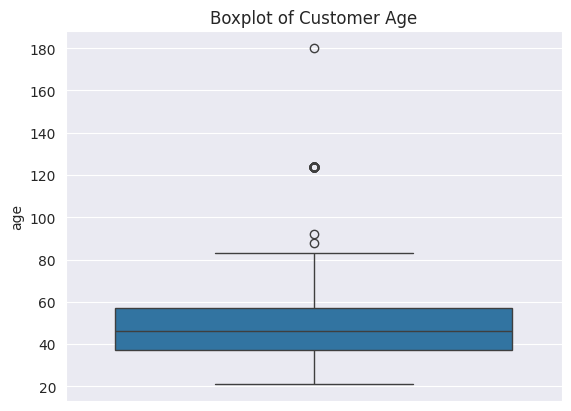

In [9]:
# Find age outliers and replace them with the median age
sns.boxplot(df_demographics['age'])
plt.title('Boxplot of Customer Age')
plt.show()

In [10]:
# Calculate the median age
median_age = df_demographics['age'].median()
print(f"Median age: {median_age}")

Median age: 46.0


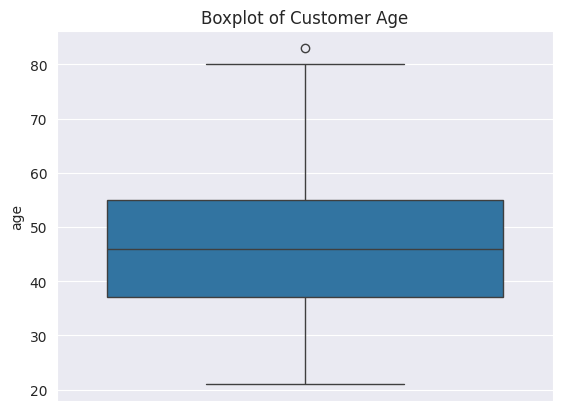

In [11]:
# Replace age outliers with the median age
max_age = df_demographics['age'].quantile(0.75) + 1.5 * (df_demographics['age'].quantile(0.75) - df_demographics['age'].quantile(0.25))
df_demographics['age'] = np.where(df_demographics['age'] > max_age, median_age, df_demographics['age'])

# Check the boxplot of age again
sns.boxplot(df_demographics['age'])
plt.title('Boxplot of Customer Age')
plt.show()

# Part 1 - Descriptive Statistics
- Calculate mean, median, and mode of transaction amounts.
- Integrate Probability Density Function (PDF) to model the probability distribution.
- Compute the expected value of transaction amounts.

For transaction amounts, we have two parameters: 
- Standard Cost (SC) and
- List Price (LP).

List Price is the price at which a product or service is advertised or listed for sale. It's also sometimes referred to as the "sticker price" or the "retail price." The list price may not always reflect the actual price paid by customers, as discounts or promotions may apply.

Standard cost is the predetermined cost of manufacturing a product or providing a service, based on factors such as materials, labor, and overhead. It represents the expected cost under normal conditions and is used for planning, budgeting, and evaluating performance. Standard cost can serve as a benchmark against which actual costs are compared to assess efficiency and variance.

In [12]:
# Calculate mean, median, and mode of transaction amounts.

# list_price
mean = df['list_price'].mean()
median = df['list_price'].median()
mode = df.mode(axis=0)['list_price'][0]

print(f"Mean: {mean}, Median: {median}, Mode: {mode}")

# standard_cost

# remove $ sign and convert to float
df['standard_cost'] = df['standard_cost'].replace('[\$,]', '', regex=True).astype(float) 

mean_std_cost = df['standard_cost'].mean()
median_std_cost = df['standard_cost'].median()
mode_std_cost = df.mode(axis=0)['standard_cost'][0]

print(f"Mean: {mean_std_cost}, Median: {median_std_cost}, Mode: {mode_std_cost}")

Mean: 1107.9978659799021, Median: 1163.89, Mode: 2091.47
Mean: 556.0469512209311, Median: 507.58, Mode: 388.92


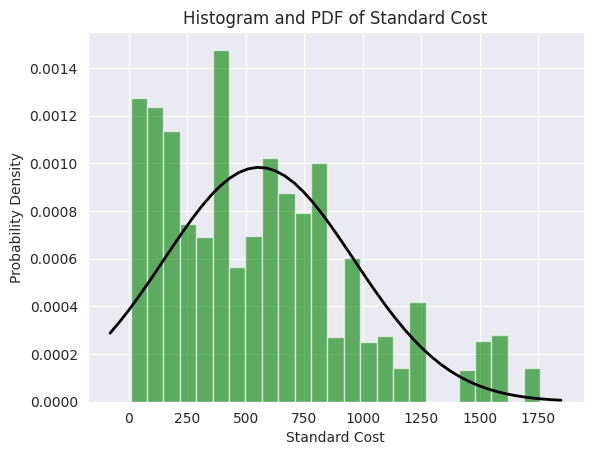

Estimated Mean: 556.0469512209311
Estimated Standard Deviation: 405.9454095958903


In [13]:
df.dropna(subset=['list_price', 'standard_cost'], inplace=True)
# Fit Gaussian distribution to 'standard_cost' column
mu, std = norm.fit(df['standard_cost'])

# Plot histogram of the data
plt.hist(df['standard_cost'], bins=25, density=True, alpha=0.6, color='g')

# Plot PDF of the fitted Gaussian distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 50)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

plt.xlabel('Standard Cost')
plt.ylabel('Probability Density')
plt.title('Histogram and PDF of Standard Cost')
plt.show()

print("Estimated Mean:", mu)
print("Estimated Standard Deviation:", std)

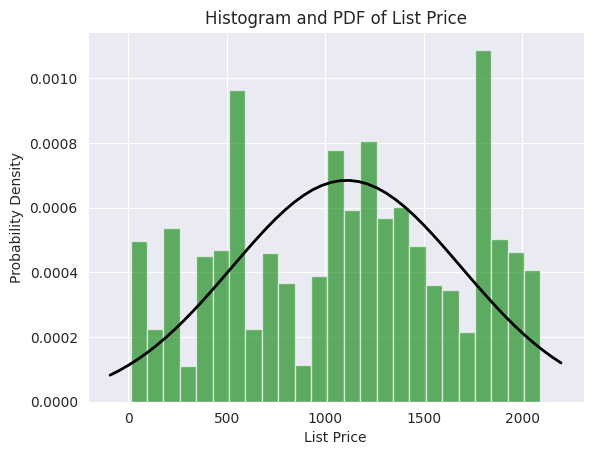

Estimated Mean: 1107.9978659799021
Estimated Standard Deviation: 582.7557459039022


In [14]:
# Fit Gaussian distribution to 'list_price' column
mu, std = norm.fit(df['list_price'])

# Plot histogram of the data
plt.hist(df['list_price'], bins=25, density=True, alpha=0.6, color='g')

# Plot PDF of the fitted Gaussian distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 50)

p = norm.pdf(x, mu, std)

plt.plot(x, p, 'k', linewidth=2)

plt.xlabel('List Price')
plt.ylabel('Probability Density')
plt.title('Histogram and PDF of List Price')
plt.show()

print("Estimated Mean:", mu)
print("Estimated Standard Deviation:", std)

# Part 2 - Correlation Analysis

## Do people who don't own a car spend more money on bicycles on average?

In [15]:
# from transaction dataset get the total amount spent by each customer
df_total_spent = df.groupby('customer_id').agg({'list_price': 'sum'}).reset_index()
df_total_spent.rename(columns={'list_price': 'total_spent'}, inplace=True)

# merge it with the owns_car column from the customer demographics dataset
df_total_spent = df_total_spent.merge(df_demographics[['customer_id', 'owns_car']], on='customer_id', how='left')

df_total_spent.head()

,customer_id,total_spent,owns_car
0,1,9084.45,Yes
1,2,4149.07,Yes
2,3,9888.23,Yes
3,4,1047.72,No
4,5,5903.20,Yes


Car owners (1770) - Mean: 6320.06313559322, Median: 6050.465, Mode: 748.17
Non car owners (1723) - Mean: 6241.23625652931, Median: 5926.59, Mode: 569.56


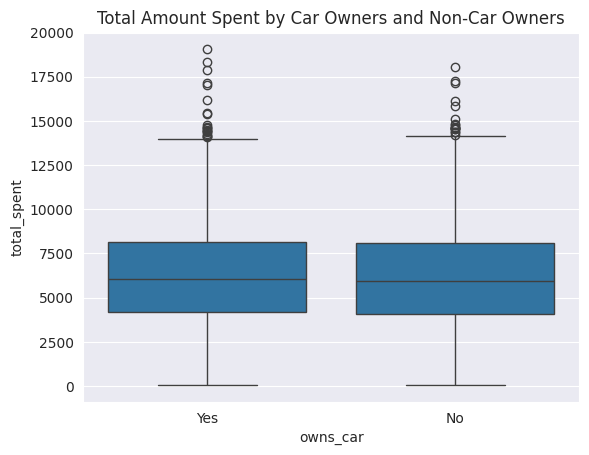

In [16]:
car_owners = df_total_spent[df_total_spent['owns_car'] == 'Yes']

# Print mean, median, and mode of total amount spent by car owners
mean_car_owners = car_owners['total_spent'].mean()
median_car_owners = car_owners['total_spent'].median()
mode_car_owners = car_owners['total_spent'].mode()[0]

print(f"Car owners ({len(car_owners)}) - Mean: {mean_car_owners}, Median: {median_car_owners}, Mode: {mode_car_owners}")

non_car_owners = df_total_spent[df_total_spent['owns_car'] == 'No']

# Print mean, median, and mode of total amount spent by non-car owners
mean_non_car_owners = non_car_owners['total_spent'].mean()
median_non_car_owners = non_car_owners['total_spent'].median()
mode_non_car_owners = non_car_owners['total_spent'].mode()[0]

print(f"Non car owners ({len(non_car_owners)}) - Mean: {mean_non_car_owners}, Median: {median_non_car_owners}, Mode: {mode_non_car_owners}")

# Show in a boxplot
sns.boxplot(x='owns_car', y='total_spent', data=df_total_spent)
plt.title('Total Amount Spent by Car Owners and Non-Car Owners')
plt.show()

#### It might seem like car owners spend a little bit more on average than non-car owners. If the correlation is statistically important, we can propose a hypothesis that this effect can be attributed to the fact that car owners are generally wealthier than non-car owners and ready to spend more on bicycles. But before we can make any conclusions, we need to perform a statistical test to check if the difference in means is statistically significant. We can use a t-test for this purpose.

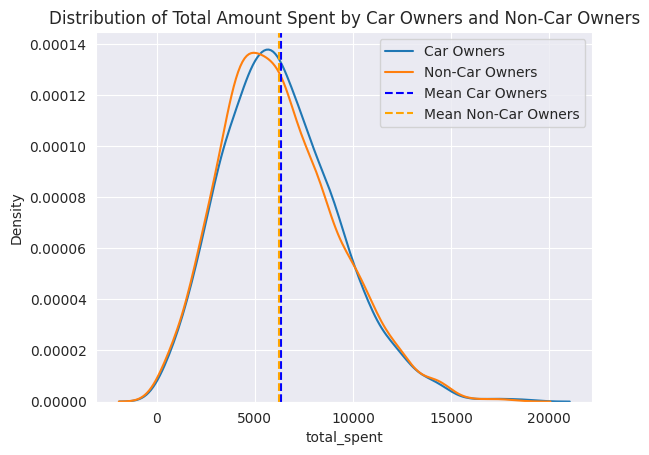

In [17]:
# plot the distribution of total amount spent by car owners and non-car owners and compare mean
sns.kdeplot(car_owners['total_spent'], label='Car Owners')
sns.kdeplot(non_car_owners['total_spent'], label='Non-Car Owners')
plt.axvline(mean_car_owners, color='blue', linestyle='--', label='Mean Car Owners')
plt.axvline(mean_non_car_owners, color='orange', linestyle='--', label='Mean Non-Car Owners')
plt.title('Distribution of Total Amount Spent by Car Owners and Non-Car Owners')
plt.legend()
plt.show()

In [18]:
# Perform t-test to check if the difference in means is statistically significant
from scipy.stats import ttest_ind

t_stat, p_val = ttest_ind(car_owners['total_spent'], non_car_owners['total_spent'])
print(f"t-statistic: {t_stat}, p-value: {p_val}")

t-statistic: 0.7907534306620937, p-value: 0.4291416051776008


#### The p-value is much less than 0.05, so we can reject the null hypothesis and conclude that the difference in means has no statistical significance. This means that the difference in the amount spent by car owners and non-car owners is not significant and can be attributed to random chance.

### Busted!

## Do people who live in certain states spend more money on bicycles on average?

In [19]:
# merge the total amount spent by each customer with the state they live in
df_total_spent = df_total_spent.merge(df_addresses[['customer_id', 'state']], on='customer_id', how='left')

# get the mean total amount spent by customers in each state
df_state_spent = df_total_spent.groupby('state').agg({'total_spent': 'mean'}).reset_index()
df_state_spent = df_state_spent.sort_values(by='total_spent', ascending=False)

# add the number of customers in each state
df_state_spent = df_state_spent.merge(df_total_spent['state'].value_counts().reset_index())

df_state_spent.head()

,state,total_spent,count
0,QLD,6357.244818,743
1,VIC,6304.263705,880
2,NSW,6236.956468,1866


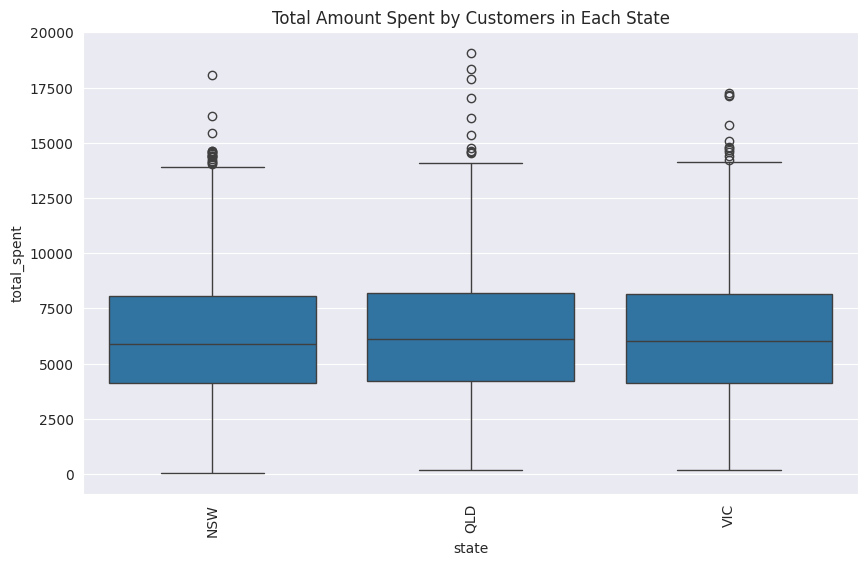

In [20]:
# plot the amounts spent by customers in each state in boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='state', y='total_spent', data=df_total_spent)
plt.title('Total Amount Spent by Customers in Each State')
plt.xticks(rotation=90)
plt.show()

#### Although, our e-commerce company has much more customers in New South Wales (NSW), all the customers tend to spend on average the same amount of money on bicycles, regardless of the state they live in. The difference in means is not statistically significant, as we can see from the boxplot.

## It seems like our company is based in New South Wales. Do customers in other states prefer to order bicycles online?

In [21]:
# for each state, calculate the percentage of transactions made online

for state in df_addresses['state'].unique():
    customers = df_addresses[df_addresses['state'] == state]['customer_id']
    state_transactions = df[df['customer_id'].isin(customers)]
    state_online = state_transactions['online_order'].value_counts(normalize=True).iloc[0] * 100
    print(f'Percentage of transactions made online in {state}: {state_online} %')

Percentage of transactions made online in NSW: 50.10613662678502 %
Percentage of transactions made online in QLD: 50.0965250965251 %
Percentage of transactions made online in VIC: 50.28524857375714 %


#### It seems like the percentage of transactions made online is almost the same in all states. This means that customers in all states prefer to order bicycles online equally.

## Do younger customers prefer to order bicycles online?

In [22]:
# create a dataframe with online_order and customer_age columns
df_online_age = df.merge(df_demographics[['customer_id', 'age']], on='customer_id', how='left')
df_online_age = df_online_age[['online_order', 'age']]
df_online_age.head()

,online_order,age
0,False,69.0
1,True,45.0
2,False,46.0
3,False,62.0
4,True,27.0


In [23]:
# create a dataframe with age and percentage of transactions made online
df_age_online = df_online_age.groupby('age').agg({'online_order': 'mean'}).reset_index()
df_age_online = df_age_online.sort_values(by='age')

df_age_online

,age,online_order
0,21.0,0.6
1,22.0,0.454545
2,23.0,0.484694
3,24.0,0.47331
4,25.0,0.474531
5,26.0,0.468085
6,27.0,0.543269
7,28.0,0.524554
8,29.0,0.520988
9,30.0,0.478764


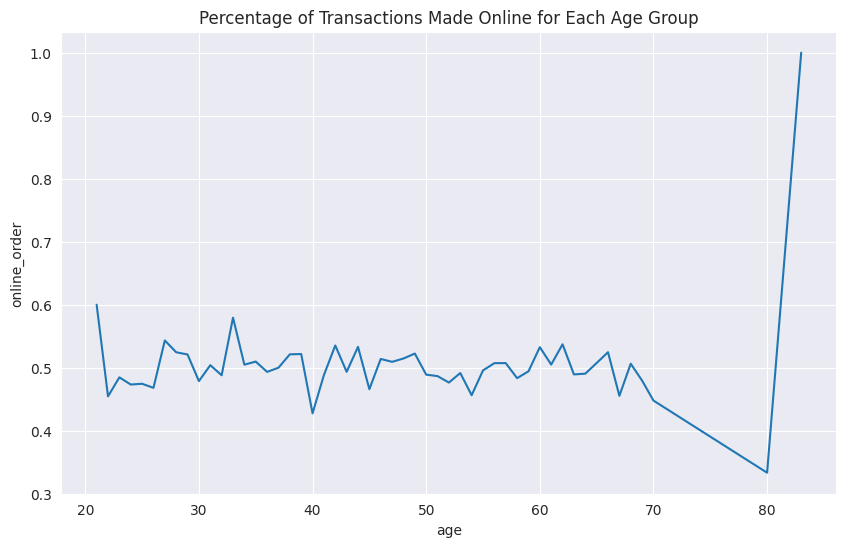

In [24]:
# plot the PDF of the percentage of transactions made online for each age group
plt.figure(figsize=(10, 6))
sns.lineplot(x='age', y='online_order', data=df_age_online)
plt.title('Percentage of Transactions Made Online for Each Age Group')
plt.show()

## Do customers of different ages prefer different brands of bicycles?

In [25]:
# create a new dataframe with bicycle brand and customer age
df_age_brand = df.merge(df_demographics[['customer_id', 'age']], on='customer_id', how='left')
df_age_brand = df_age_brand[['brand', 'age']]
df_age_brand.head()

,brand,age
0,Solex,69.0
1,Trek Bicycles,45.0
2,OHM Cycles,46.0
3,Norco Bicycles,62.0
4,Giant Bicycles,27.0


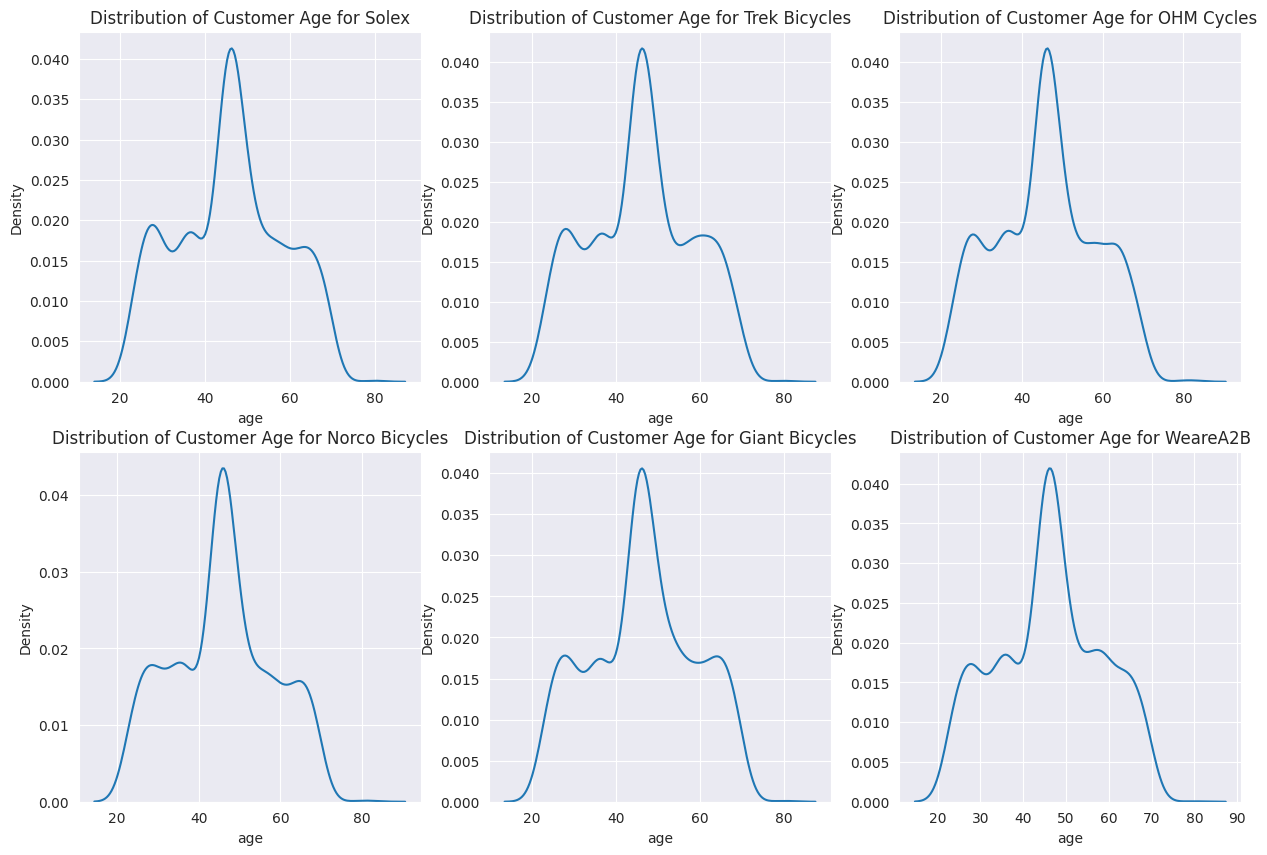

In [26]:
# plot the distributions of customer age for each brand in subplots
plt.figure(figsize=(15, 10))
brands = df_age_brand['brand'].unique()
for i, brand in enumerate(brands):
    plt.subplot(2, 3, i+1)
    sns.kdeplot(df_age_brand[df_age_brand['brand'] == brand]['age'], label=brand)
    plt.title(f'Distribution of Customer Age for {brand}')
plt.show()

In [27]:
# print out the statistical summary of customer age for each brand
for brand in brands:
    print(f"Brand: {brand}")
    count = df_age_brand[df_age_brand['brand'] == brand].shape[0]
    mean = df_age_brand[df_age_brand['brand'] == brand]['age'].mean()
    median = df_age_brand[df_age_brand['brand'] == brand]['age'].median()
    mode = df_age_brand[df_age_brand['brand'] == brand]['age'].mode()[0]
    std = df_age_brand[df_age_brand['brand'] == brand]['age'].std()
    print(f"Count: {count}, Mean: {mean:.2f}, Median: {median:.0f}, Mode: {mode:.0f}, Standard Deviation: {std:.2f}")

Brand: Solex
Count: 4253, Mean: 45.80, Median: 46, Mode: 46, Standard Deviation: 12.49
Brand: Trek Bicycles
Count: 2990, Mean: 45.94, Median: 46, Mode: 46, Standard Deviation: 12.36
Brand: OHM Cycles
Count: 3043, Mean: 45.83, Median: 46, Mode: 46, Standard Deviation: 12.38
Brand: Norco Bicycles
Count: 2910, Mean: 45.84, Median: 46, Mode: 46, Standard Deviation: 12.35
Brand: Giant Bicycles
Count: 3312, Mean: 46.37, Median: 46, Mode: 46, Standard Deviation: 12.51
Brand: WeareA2B
Count: 3295, Mean: 46.09, Median: 46, Mode: 46, Standard Deviation: 12.32


# Part 3 - Time Series Analysis

Analyze temporal patterns in customer purchases over time, identifying peak buying
periods and any significant variations

## Analyse total sales over time

In [28]:
# create a new dataframe with the transaction date and total amount spent (by summing up the list price)
df_time_series = df[['transaction_date', 'list_price']]
df_time_series = df_time_series.groupby('transaction_date').agg({'list_price': 'sum'}).reset_index()
df_time_series.head()

,transaction_date,list_price
0,2017-01-01,60029.45
1,2017-01-02,57765.79
2,2017-01-03,60563.34
3,2017-01-04,67793.39
4,2017-01-05,74153.32


In [29]:
# check for missing dates
date_range = pd.date_range(start=df_time_series['transaction_date'].min(), end=df_time_series['transaction_date'].max())
missing_dates = date_range[~date_range.isin(df_time_series['transaction_date'])]
print(f"Missing dates: {missing_dates}")

Missing dates: DatetimeIndex([], dtype='datetime64[ns]', freq='D')


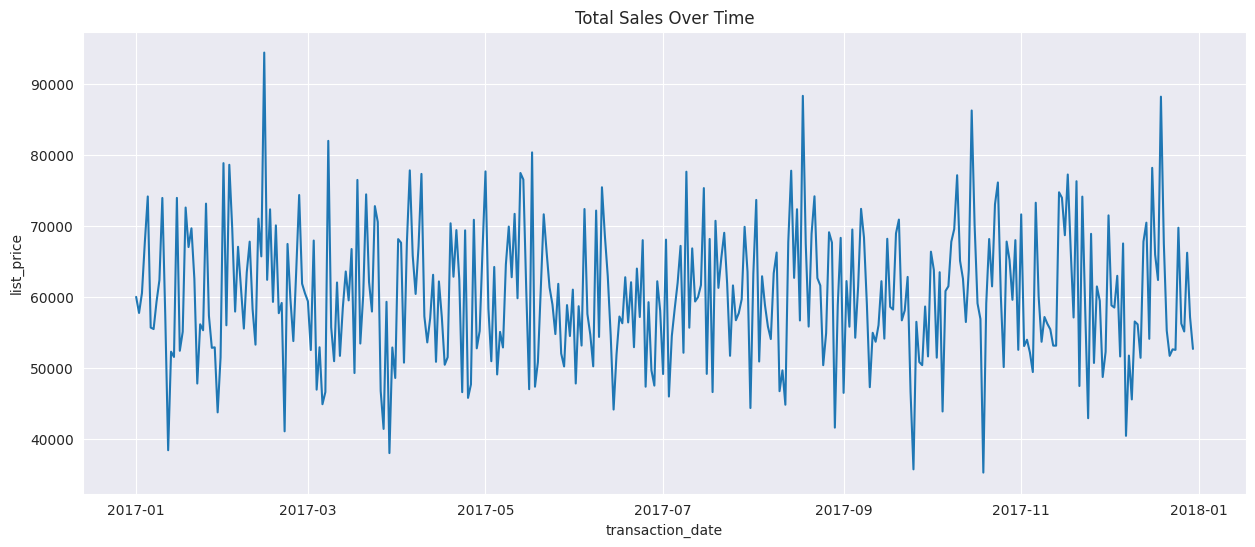

In [30]:
# plot the total sales over time
plt.figure(figsize=(15, 6))
sns.lineplot(x='transaction_date', y='list_price', data=df_time_series)
plt.title('Total Sales Over Time')
plt.show()

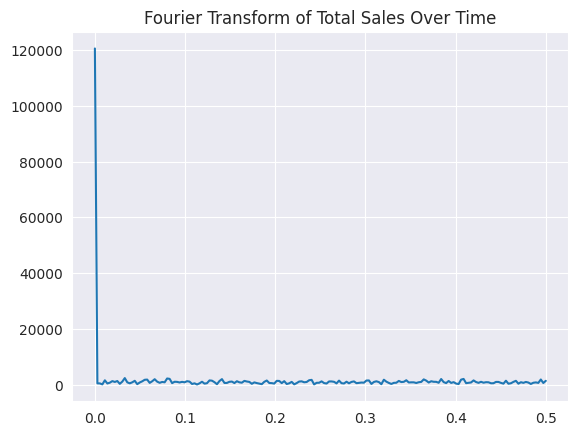

In [31]:
# Apply Fourier Transform to the time series data to split the time series into its frequency components
from scipy.fft import fft

yf = fft(df_time_series['list_price'].values)
xf = np.linspace(0.0, 1.0 / 2.0, len(df_time_series) // 2)

plt.plot(xf, 2.0/len(df_time_series) * np.abs(yf[0:len(df_time_series)//2]))
plt.title('Fourier Transform of Total Sales Over Time')
plt.show()

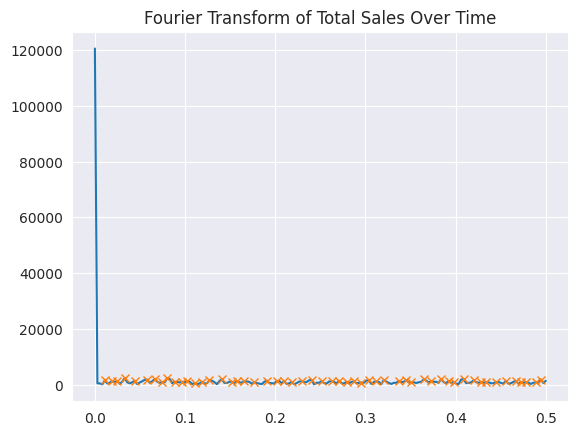

In [32]:
# Extract and plot each component of the Fourier Transform
from scipy.signal import find_peaks

peaks, _ = find_peaks(2.0/len(df_time_series) * np.abs(yf[0:len(df_time_series)//2]), height=0.1)
plt.plot(xf, 2.0/len(df_time_series) * np.abs(yf[0:len(df_time_series)//2]))
plt.plot(xf[peaks], 2.0/len(df_time_series) * np.abs(yf[0:len(df_time_series)//2])[peaks], "x")
plt.title('Fourier Transform of Total Sales Over Time')
plt.show()

Dominant Periodicity: 90 days, Dominant Amplitude: 1523.48


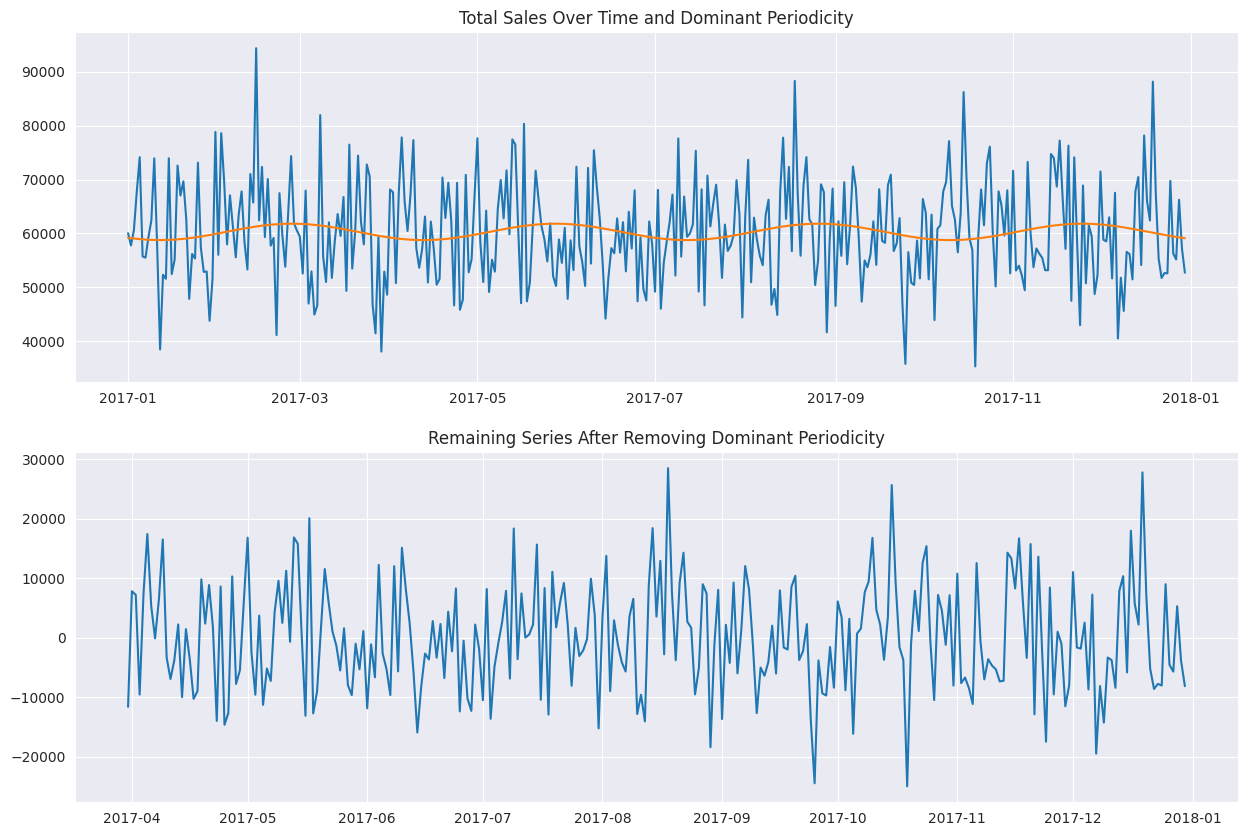

In [33]:
# Get the dominant periodicity
dominant_period = 1 / xf[peaks][0]
dominant_amplitude = 2.0/len(df_time_series) * np.abs(yf[0:len(df_time_series)//2])[peaks][0]
zero_amplitude = df_time_series['list_price'].mean()
phase = np.angle(yf[peaks][0])
print(f"Dominant Periodicity: {dominant_period:.0f} days, Dominant Amplitude: {dominant_amplitude:.2f}")

def periodic(date):
    days = (date - df_time_series['transaction_date'].min()).days
    return dominant_amplitude * np.sin(2 * np.pi / dominant_period * days + phase) + zero_amplitude

remaining_series = df_time_series['list_price'] - df_time_series['list_price'].rolling(window=int(dominant_period)).mean()

# plot the remaining series and the dominant periodicity in different subplots one below the other
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
ax[0].plot(df_time_series['transaction_date'], df_time_series['list_price'])
ax[0].plot(df_time_series['transaction_date'], [periodic(date) for date in df_time_series['transaction_date']])
ax[0].set_title('Total Sales Over Time and Dominant Periodicity')
ax[1].plot(df_time_series['transaction_date'], remaining_series)
ax[1].set_title('Remaining Series After Removing Dominant Periodicity')
plt.show()